# Python Portion of Take Home

In [1]:
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import getpass
import warnings
warnings.filterwarnings("ignore")

In [2]:
path  = getpass.getpass(prompt="Path: ")

Path: ········


### Data Preparation

In [3]:
#Extracting information for labeling columns
carriers_c = pd.read_csv('{}carriers_table.csv'.format(path),header='infer')
flights_small_c = pd.read_csv('{}flights_table.csv'.format(path),header='infer')
weekdays_c = pd.read_csv('{}weekdays_table.csv'.format(path),header='infer')
months_c = pd.read_csv('{}months_table.csv'.format(path),header='infer')

In [4]:
#Using information from the previous cell to name columns
carriers = pd.read_csv('{}carriers.csv'.format(path))
carriers.columns = list(carriers_c.columns.values)

flights_small = pd.read_csv('{}flights-small.csv'.format(path))
flights_small.columns = list(flights_small_c.columns.values)
flights_small.rename(columns={'day_of_week_id':'did'},inplace=True)

weekdays = pd.read_csv('{}weekdays.csv'.format(path))
weekdays.columns = list(weekdays_c.columns.values)
add = pd.DataFrame([[1,'Monday']],columns=['did','day_of_week'])
weekdays = weekdays.append(add)

# * Q1

In [5]:
#Selecting relevant columns from flights table
max_flight = flights_small[['carrier_id','origin_city','dest_city','price']]

#Cleaning up city names and converting to lower case for consistency
max_flight['origin_city'] = max_flight['origin_city'].map(lambda x:x[:-3].lower())
max_flight['dest_city'] = max_flight['dest_city'].map(lambda x:x[:-3].lower())

#Selecting flights between seattle and new york 
a = max_flight[(max_flight['origin_city']=='seattle') & (max_flight['dest_city']=='new york')]
b = max_flight[(max_flight['dest_city']=='seattle') & (max_flight['origin_city']=='new york')]
max_price = pd.concat([a,b],axis=0)[['carrier_id','price']].groupby('carrier_id').max().reset_index()
max_price

,carrier_id,price
0,AA,991
1,B6,996
2,DL,999


Text(0.5, 1.0, 'Maximum Price across Carriers')

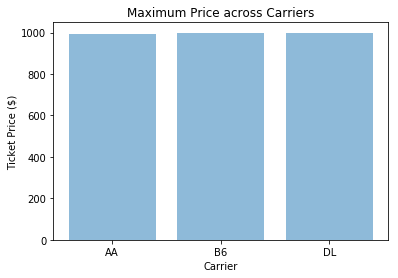

In [6]:
cid = list(max_price.carrier_id)
y_pos = np.arange(len(cid))
price = list(max_price.price)

plt.bar(y_pos, price, align='center', alpha=0.5)
plt.xticks(y_pos, cid)
plt.ylabel('Ticket Price ($)')
plt.xlabel('Carrier')
plt.title('Maximum Price across Carriers')

# *Q2
* I assumed that 'AS' is the carrier id for Alaska Airline

In [7]:
#Merge weekdays data with main data
merged = pd.merge(flights_small,weekdays,how='left',on='did')

#Cleaning up city names and converting to lower case for consistency
merged['origin_city'] = merged['origin_city'].map(lambda x:x[:-3].lower())
merged['dest_city'] = merged['dest_city'].map(lambda x:x[:-3].lower())

#select relevant columns
merged = merged[['carrier_id','origin_city','dest_city','day_of_week','price']]
sel_merged = merged[(merged['carrier_id']=='AS') & (merged['origin_city']=='seattle') & (merged['dest_city']=='boston')]

In [8]:
#checking for missing data
sel_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155 entries, 60106 to 788583
Data columns (total 5 columns):
carrier_id     155 non-null object
origin_city    155 non-null object
dest_city      155 non-null object
day_of_week    155 non-null object
price          155 non-null int64
dtypes: int64(1), object(4)
memory usage: 4.8+ KB


In [9]:
#Aggregating by day of the week
table_dow = sel_merged[['day_of_week','price']].groupby('day_of_week').mean().reset_index()
table_dow

,day_of_week,price
0,Friday,536.80
1,Monday,519.20
2,Saturday,725.16
3,Sunday,563.08
4,Thursday,524.95
5,Tuesday,544.50
6,Wednesday,538.55


Text(0.5, 1.0, 'Average Ticket Price by Day of Week')

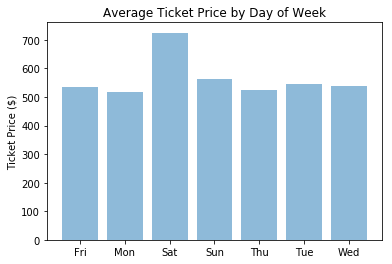

In [10]:
cid = list(table_dow.day_of_week.map(lambda x:x[:3])) #shorting names
y_pos = np.arange(len(cid))
price = list(table_dow.price)

plt.bar(y_pos, price, align='center', alpha=0.5)
plt.xticks(y_pos, cid)
plt.ylabel('Ticket Price ($)')
plt.title('Average Ticket Price by Day of Week')

# *Q3

#### Assumptions
* Cost is not a constraint
* Actual time accounts for departure and arrival delays

In [11]:
# Inspecting the data set
flights_small.head(3)

,fid,month_id,day_of_month,did,carrier_id,flight_num,origin_city,origin_state,dest_city,dest_state,departure_delay,taxi_out,arrival_delay,canceled,actual_time,distance,capacity,price
0,2,7,2,6,AA,1,New York NY,New York,Los Angeles CA,California,-7,13,-10,0,344,2475,11,817
1,3,7,3,7,AA,1,New York NY,New York,Los Angeles CA,California,-1,17,-4,0,344,2475,14,789
2,4,7,4,1,AA,1,New York NY,New York,Los Angeles CA,California,-9,20,17,0,373,2475,3,523


In [12]:
#Select relevant columns
far_travel = flights_small[['carrier_id','flight_num','origin_city','dest_city','departure_delay','arrival_delay','actual_time','distance']]
long_distance = far_travel[far_travel.origin_city=='Seattle WA'].sort_values('distance',ascending=False).reset_index()
long_distance = long_distance.drop(['index'],axis=1)
long_distance.head()

,carrier_id,flight_num,origin_city,dest_city,departure_delay,arrival_delay,actual_time,distance
0,AA,1070,Seattle WA,Miami FL,-2,-6,342,2724
1,AA,1070,Seattle WA,Miami FL,5,-8,333,2724
2,AA,1070,Seattle WA,Miami FL,-3,9,358,2724
3,AA,1070,Seattle WA,Miami FL,-2,-1,347,2724
4,AA,1070,Seattle WA,Miami FL,0,4,350,2724


In [13]:
#From the above, multiple flights are tied
top_flights = long_distance[(long_distance.distance==2724)].sort_values('actual_time')
top_flights.head()

,carrier_id,flight_num,origin_city,dest_city,departure_delay,arrival_delay,actual_time,distance
28,AA,1070,Seattle WA,Miami FL,0,0,0,2724
9,AS,16,Seattle WA,Miami FL,44,29,323,2724
21,AA,1070,Seattle WA,Miami FL,10,-12,324,2724
5,AS,16,Seattle WA,Miami FL,3,-4,331,2724
18,AA,1070,Seattle WA,Miami FL,-2,-17,331,2724


In [14]:
#Since the first row is obviously incorrect, let's remove it
top_flights = top_flights[(long_distance.actual_time>0)]

#Answer
print (top_flights[['carrier_id','flight_num','actual_time','distance']].iloc[0])

carrier_id       AS
flight_num       16
actual_time     323
distance       2724
Name: 9, dtype: object


If we had enough data for both AS 16 and AA 1070, we could have compared their averages (t-test) to determine which one has the 
lower time.